# Less-Referenced Mosaic

This notebook provides a cross-section of the Less-Referenced Mosaic creation process.

# Setup

## Imports

In [1]:
import copy
import os

In [2]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
import yaml

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('white')

In [4]:
from night_horizons import utils, preprocess, reference, mosaic, raster, pipelines

## Settings

In [5]:
with open('./config.yml', "r", encoding='UTF-8') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
local_settings = {
    'mosaic_filepath': 'mosaics/referenced3.tiff',
    'random_state': 16849,
    'train_size': 1,

    # This set of choices assumes we have really good starting positions.
    # This is useful for debugging.
    # 'padding_factor': 0.05,
    'padding_factor': 0.05,
    'use_approximate_georeferencing': False,
}
settings.update(local_settings)

## Parse Settings

In [7]:
settings['mosaic_filepath'] = os.path.join(settings['data_dir'], settings['mosaic_filepath'])

In [8]:
for key, relpath in settings['paths_relative_to_data_dir'].items():
    settings[key] = os.path.join(settings['data_dir'], relpath)

In [9]:
random_state = check_random_state(settings['random_state'])

In [10]:
referenced_fps = utils.discover_data(settings['referenced_images_dir'], ['tif', 'tiff'], pattern=r'Geo\s\d+_\d.tif')

In [11]:
palette = sns.color_palette(settings['color_palette'])

In [12]:
crs = settings['crs']

# Prepare Data
The first part is to prepare the data (AKA extract/transform/load).

## Train-Test Split

We split the data into training data (data that is georeferenced) and test data (data that is not georeferenced, or for which we don't use the georeferencing information when we're building the models).

We set the train size to some small number, because ideally the user only needs to georeference a couple of images manually.

In [13]:
settings['train_size']

1

In [14]:
fps_train, fps_test = train_test_split(referenced_fps, train_size=settings['train_size'], random_state=settings['random_state'])

## Initial, Approximate Georeferencing
We use the sensor (high-altitude balloon) positions to provide approximate georeferencing, which will be useful for saving computational time when building the unreferenced mosaic.

In [15]:
# This is the pipeline for approximate georeferencing
sensor_georeference_pipeline = Pipeline([
    ('nitelite', preprocess.NITELitePreprocesser(
        output_columns=['filepath', 'sensor_x', 'sensor_y', 'camera_num'],
        crs=crs
    )),
    ('sensor_georeference', reference.SensorGeoreferencer(crs=crs, passthrough=['filepath', 'camera_num'])),
])

sensor_georeference_pipeline_y = preprocess.GeoTIFFPreprocesser(crs=crs)

In [16]:
# Get the geo-transforms used for training
geotransforms_train = sensor_georeference_pipeline_y.fit_transform(fps_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.09it/s]


In [17]:
# Train the pipeline
sensor_georeference_pipeline.fit(
    fps_train,
    geotransforms_train,
    nitelite__img_log_fp=settings['img_log_fp'],
    nitelite__imu_log_fp=settings['imu_log_fp'],
    nitelite__gps_log_fp=settings['gps_log_fp'],
)

Pipeline(steps=[('nitelite',
                 NITELitePreprocesser(crs=<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mer...
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
,
                                     passthrough=['filepath', 'camera_num']))])

In [18]:
# Get the approximate georeferences for the data we'll be testing
if settings['use_approximate_georeferencing']:
    X_test = sensor_georeference_pipeline.predict(fps_test)
else:
    georeference_pipeline = Pipeline([
        ('nitelite', preprocess.NITELitePreprocesser(
            output_columns=['filepath', 'camera_num'],
            crs=crs
        )),
        ('georeference', preprocess.GeoTIFFPreprocesser(crs=crs, passthrough=['camera_num'])),
    ])
    X_test = georeference_pipeline.fit_transform(
        fps_test,
        nitelite__img_log_fp=settings['img_log_fp'],
        nitelite__imu_log_fp=settings['imu_log_fp'],
        nitelite__gps_log_fp=settings['gps_log_fp'],
    )

/Users/Shared/repos/night-horizons-mapmaker/night_horizons/preprocess.py:131: UserWarning: Did not successfully correlate all filepaths. n_uncorrelated = 2
  warnings.warn(w_message)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 211.62it/s]


In [19]:
# The score for the fit gives us an estimate of the error from the approximate georeferencing
first_pass_error = sensor_georeference_pipeline.score(fps_train, geotransforms_train)
padding = settings['padding_factor'] * first_pass_error

## Create the Containing Mosaic Dataset

We need to create this at this time to meet two requirements: 
1. The dataset bounds are large enough to contain all the images, not just the training images.
2. The mosaic created from the training images are saved here.

In [20]:
# # If we want to start fresh
# if os.path.isfile(settings['mosaic_filepath']) and settings['overwrite']:
#     print('Removing existing mosaic.')
#     os.remove(settings['mosaic_filepath'])

In [21]:
# mos = mosaic.Mosaic(settings['mosaic_filepath'], padding=first_pass_error * 2.)

In [22]:
# # The dataset is created during the fit.
# mos.fit(X_test[['filepath'] + preprocess.GEOTRANSFORM_COLS])

In [23]:
# # Close the dataset so we can write to it.
# mos.dataset_.FlushCache()
# mos.dataset_ = None

## Create the Starting Image for the Mosaic

The starting image is a mosaic of the images that are referenced.

In [24]:
# # We use our canned pipeline for building a referenced mosaic
# reffed_mosaic_pipeline = pipelines.MosaicPipelines.referenced_mosaic(settings['mosaic_filepath'])
# reffed_mosaic_pipeline.set_params(mosaic__exist_ok=True)

In [25]:
# # Actual creation
# reffed_mosaic_pipeline.fit_transform(fps_train)

# The Mosaic

### Initialize and Fit

In [26]:
less_reffed_mosaic = mosaic.LessReferencedMosaic(
    filepath=settings['mosaic_filepath'],
    padding=padding,
    file_exists='overwrite',
)

In [27]:
# This creates the dataset and adds the referenced mosaic.
less_reffed_mosaic.fit(
    X=geotransforms_train,
    approx_geotransforms=X_test[preprocess.GEOTRANSFORM_COLS],
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


## Convert geotransforms to pixel offsets and counts

In [28]:
(
    X_test['x_off'], X_test['y_off'],
    X_test['x_size'], X_test['y_size']
) = less_reffed_mosaic.bounds_to_offset(
    X_test['x_min'], X_test['x_max'],
    X_test['y_min'], X_test['y_max'],
    padding = less_reffed_mosaic.padding
)

In [29]:
(
    geotransforms_train['x_off'], geotransforms_train['y_off'],
    geotransforms_train['x_size'], geotransforms_train['y_size']
) = less_reffed_mosaic.bounds_to_offset(
    geotransforms_train['x_min'], geotransforms_train['x_max'],
    geotransforms_train['y_min'], geotransforms_train['y_max'],
    padding = less_reffed_mosaic.padding
)

## Determine order of iteration

In [30]:
# Camera order of iteration--1 is the nader camera, so that's first
X_test['camera_order'] = X_test['camera_num'].map({0: 1, 1: 0, 2: 2})

In [31]:
# Proximity order of iteration
center_coords = geotransforms_train[['x_center', 'y_center']].mean()
offset = X_test[['x_center', 'y_center']] - center_coords
X_test['d_to_center'] = np.linalg.norm(offset, axis=1)

In [32]:
# Actual sort
X_iter = X_test.sort_values(['camera_order', 'd_to_center'])
X_iter['order'] = np.arange(len(X_iter))
iter_inds = X_iter.index

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


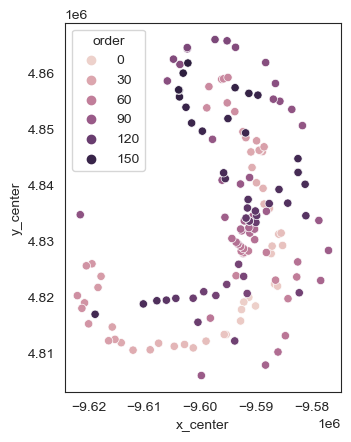

In [33]:
# Let's take a look.
sp = sns.scatterplot(
    data=X_iter,
    x='x_center',
    y='y_center',
    hue='order',
)
sp.set_aspect('equal')

## First Image
We'll test the first loop in greater detail than the others.

In [34]:
i = 0
row = X_iter.iloc[i]

In [35]:
# The empty image at the time of the first loop
mosaic_img = less_reffed_mosaic.dataset_.ReadAsArray().transpose(1, 2, 0)

### Search Region in the Context of the Full Mosaic

In [36]:
# Expected bounds
x_off = row['x_off']
y_off = row['y_off']
x_size = row['x_size']
y_size = row['y_size']

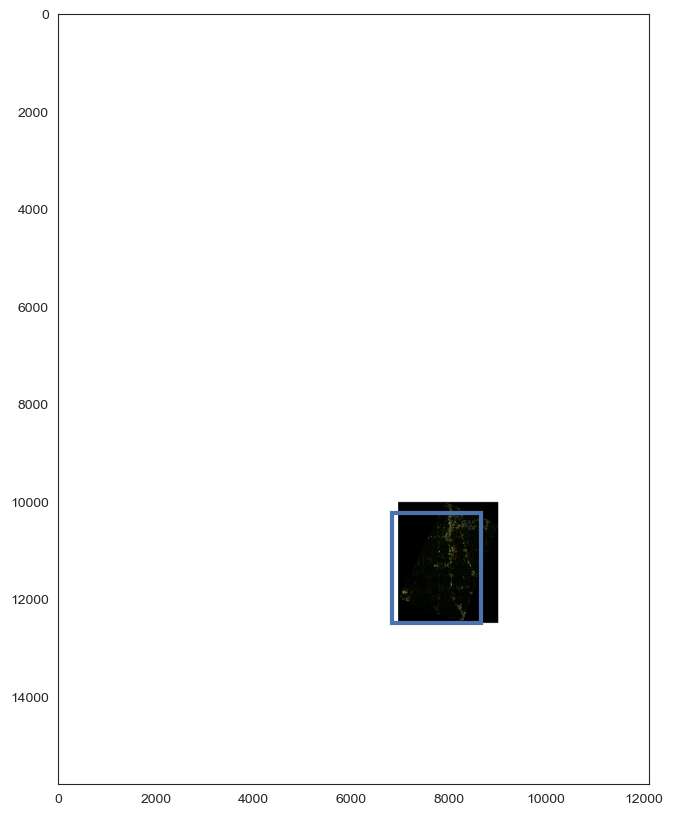

In [37]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

# Current mosaic
ax.imshow(mosaic_img)

# The first image location
rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)

### Search Region Image 

In [38]:
# The existing mosaic at this location
dst_img = less_reffed_mosaic.get_image(x_off, y_off, x_size, y_size)

In [39]:
# At this time we expect all data added to the mosaic to be within the bounds of the search region, if we're using approximate georeferencing
if settings['use_approximate_georeferencing']:
    assert dst_img.sum() == mosaic_img.sum()

This is plotted below with matched features.

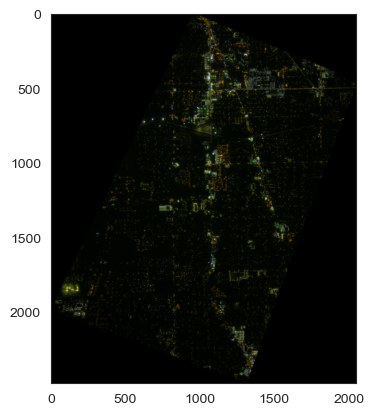

In [40]:
# Here's a zoomed in version so we know what we should be looking at.
row_train = geotransforms_train.iloc[0]
dst_img_zoom = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size']
)
plt.imshow(dst_img_zoom)

### Search Region KeyPoints
We get these for later.

In [41]:
# Get the features from the original mosaic
dst_kp, dst_des = less_reffed_mosaic.feature_detector_.detectAndCompute(dst_img, None)

In [42]:
# Transform the dst keypoints to mosaic frame
dsframe_dst_pts = cv2.KeyPoint_convert(dst_kp) + np.array([x_off, y_off])
dsframe_dst_des = copy.copy(dst_des)

### New Image

In [43]:
src_img = utils.load_image(
    row['filepath'],
    dtype=less_reffed_mosaic.dtype,
)

This is plotted below with matched features.

### Feature Matching

In [44]:
src_kp, src_des = less_reffed_mosaic.feature_detector_.detectAndCompute(src_img, None)

In [45]:
# Get and validate the transform predicted from feature matching
M, info = utils.calc_warp_transform(src_kp, src_des, dst_kp, dst_des)
assert utils.validate_warp_transform(M, less_reffed_mosaic.homography_det_min)

In [46]:
# Inspect relationship
mask = info['mask'].reshape(info['mask'].size).astype(bool)
valid_src_pts = info['matched_src_pts'].reshape((mask.size, 2))[mask]
valid_dst_pts = info['matched_dst_pts'].reshape((mask.size, 2))[mask]

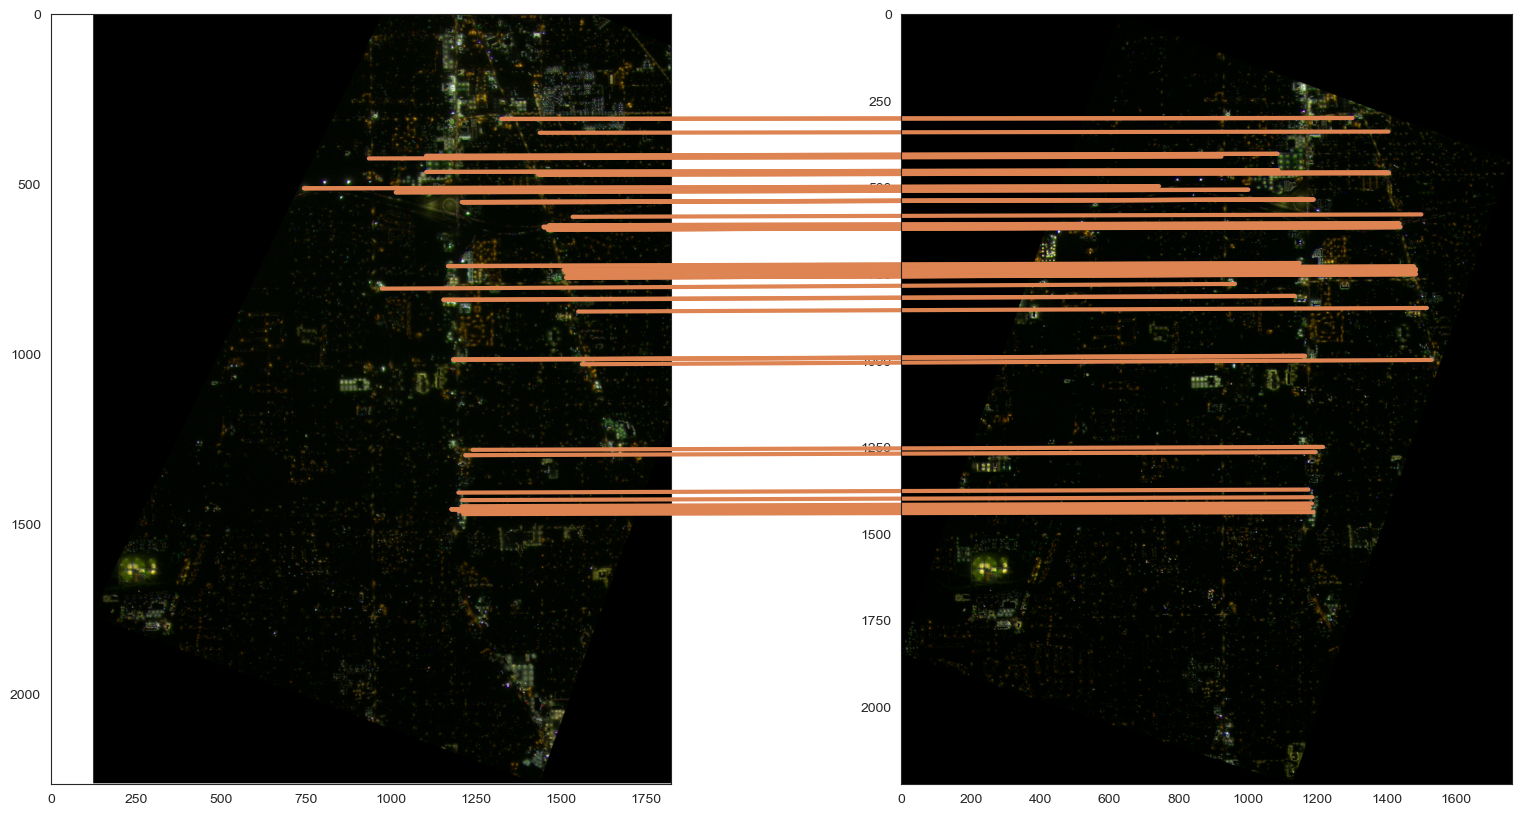

In [47]:
subplot_mosaic = [['dst_img', 'src_img']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['dst_img']
ax.imshow(dst_img)

ax = ax_dict['src_img']
ax.imshow(src_img)

for i in range(valid_src_pts.shape[0]):

    con = patches.ConnectionPatch(
        xyA=valid_dst_pts[i],
        xyB=valid_src_pts[i],
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['dst_img'],
        axesB=ax_dict['src_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

The feature matching above should look pretty good. It does as I'm writing this.

### Warp the Source Image

In [48]:
# Warp the image being fit
warped_img = utils.warp_image(src_img, dst_img, M)

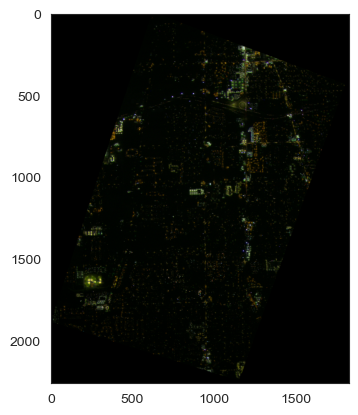

In [49]:
plt.imshow(warped_img)

In [50]:
# The warped image should have the same dimensions as the dst img
assert warped_img.shape[:2] == dst_img.shape[:2]

### Blend the images

In [51]:
blended_img = less_reffed_mosaic.blend_images(
    src_img=warped_img,
    dst_img=dst_img,
)

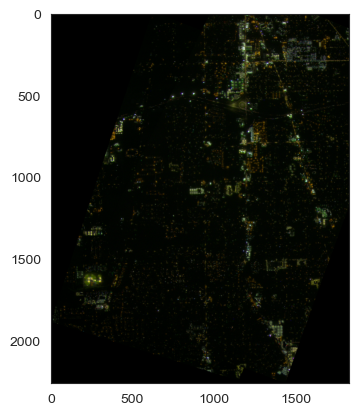

In [52]:
plt.imshow(blended_img)

### Save and look at the mosaic

In [53]:
less_reffed_mosaic.save_image(blended_img, x_off, y_off)

In [54]:
# Get the region of just the first image for comparison from before
dst_img_zoom_after = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size'],
)

In [55]:
# More content should have been added
assert dst_img_zoom_after.sum() > dst_img_zoom.sum()

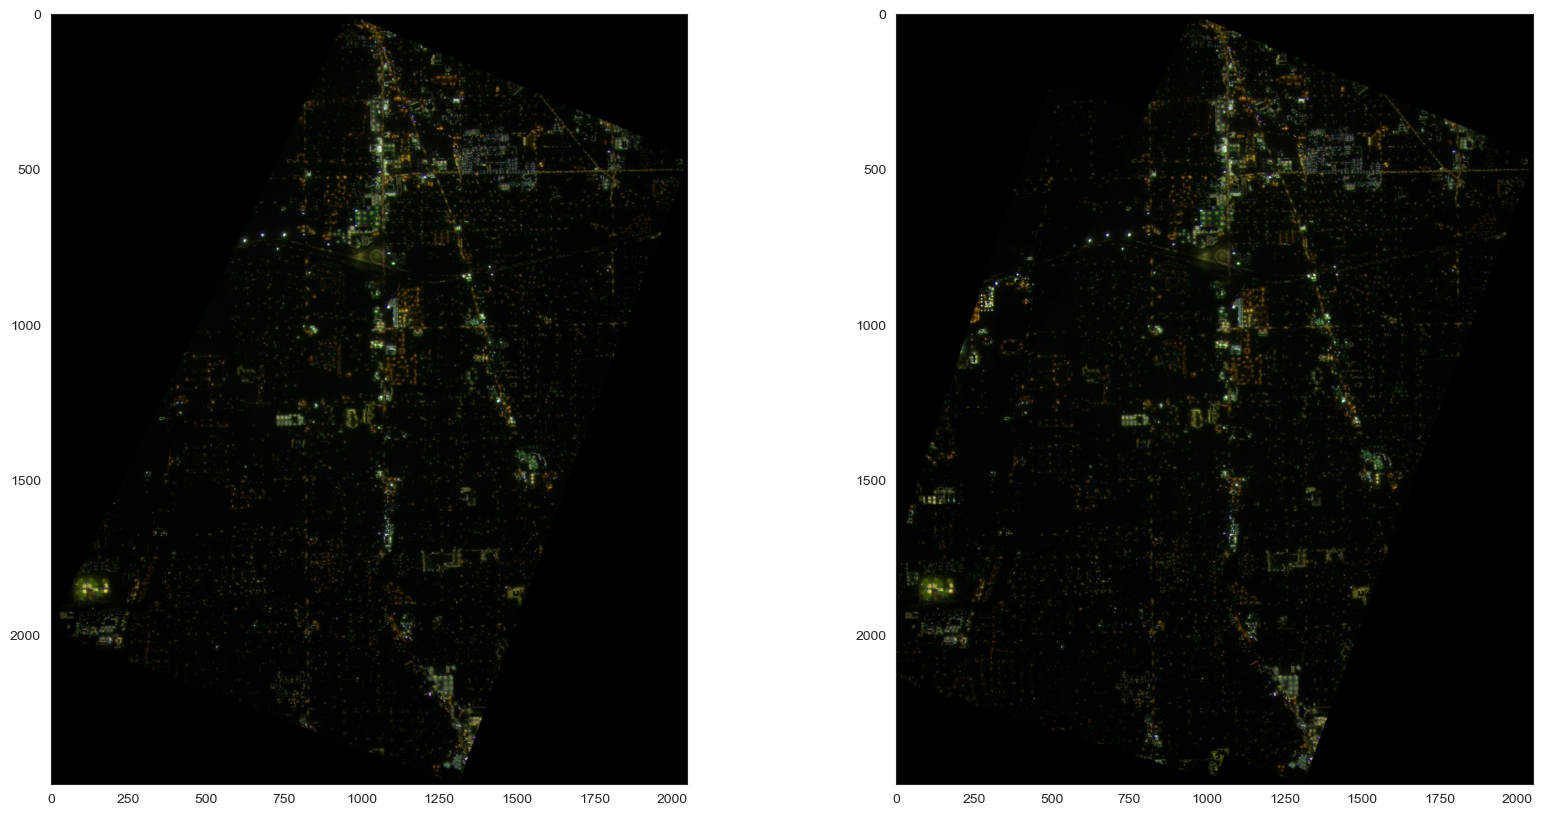

In [56]:
subplot_mosaic = [['before', 'after']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['before']
ax.imshow(dst_img_zoom)

ax = ax_dict['after']
ax.imshow(dst_img_zoom_after)

### Warp the Keypoints

In [57]:
# Transform to local frame and then the full mosaic frame
src_pts = cv2.KeyPoint_convert(src_kp)
global_src_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), M).reshape(-1, 2)
global_src_pts += np.array([x_off, y_off])

In [58]:
# Store the transformed points for the next loop
dsframe_dst_pts = np.append(dsframe_dst_pts, global_src_pts, axis=0)
dsframe_dst_des = np.append(dsframe_dst_des, src_des, axis=0)

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


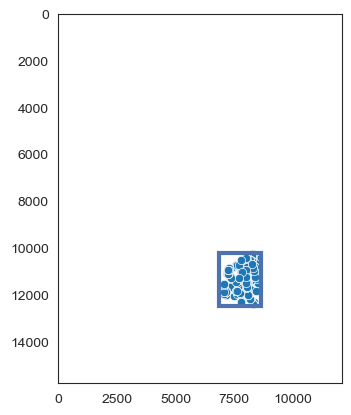

In [59]:
fig = plt.figure()
ax = plt.gca()

sns.scatterplot(
    x=dsframe_dst_pts[:,0],
    y=dsframe_dst_pts[:,1],
    ax = ax,
)

rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)

ax.set_xlim(0, less_reffed_mosaic.dataset_.RasterXSize)
ax.set_ylim(less_reffed_mosaic.dataset_.RasterYSize, 0)
ax.set_aspect('equal')

In [60]:
# Automated check that everything's in bounds
not_in_bounds = ~(
    (x_off <= dsframe_dst_pts[:,0] )
    & (dsframe_dst_pts[:,0] <= x_off + x_size)
    & (y_off <= dsframe_dst_pts[:,1] )
    & (dsframe_dst_pts[:,1] <= y_off + y_size)
)
assert not_in_bounds.sum() == 0

## Next Image

In [61]:
i = 1
row = X_iter.iloc[i]

### Preview keypoint selection

In [62]:
x_off = row['x_off']
y_off = row['y_off']
x_size = row['x_size']
y_size = row['y_size']

In [63]:
in_bounds = less_reffed_mosaic.check_bounds(
    dsframe_dst_pts,
    x_off, y_off, x_size, y_size,
)

In [64]:
assert in_bounds.sum() > 0, \
    f'No image data in the search zone for index {row.name}'

In [65]:
dst_pts = dsframe_dst_pts[in_bounds]
dst_des = dsframe_dst_des[in_bounds]

In [66]:
# At this point in the loops, *all* the points should be in bounds, if we're doing approximate georeferencing
if settings['use_approximate_georeferencing']:
    assert (~in_bounds).sum() == 0

### Call the typical function

In [67]:
return_code, info = less_reffed_mosaic.incorporate_image(row, dsframe_dst_pts, dsframe_dst_des)

In [68]:
assert return_code == 0, 'Image combined unsuccessfully.'

In [69]:
dst_img_zoom_after2 = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size'],
)

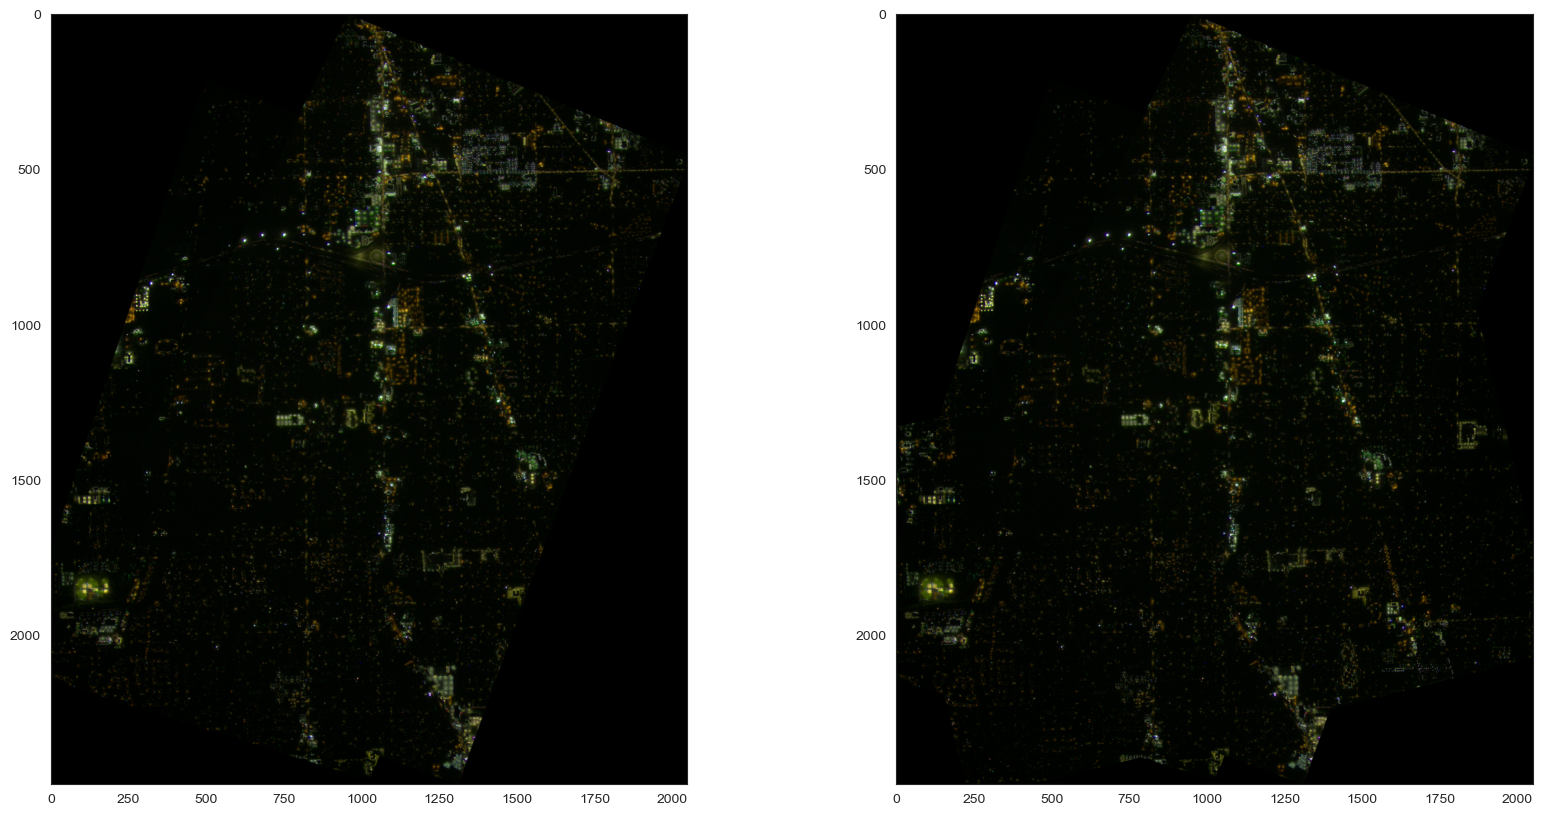

In [70]:
subplot_mosaic = [['before', 'after']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['before']
ax.imshow(dst_img_zoom_after)

ax = ax_dict['after']
ax.imshow(dst_img_zoom_after2)

## Run for a Subset

Now we'll check if it runs for a subset

In [71]:
from sklearn.model_selection import GridSearchCV

In [78]:
from sklearn.model_selection import PredefinedSplit

In [80]:
split = PredefinedSplit(np.zeros(geotransforms_train.shape[0]))

In [72]:
less_reffed_mosaic = mosaic.LessReferencedMosaic(
    filepath=settings['mosaic_filepath'],
    padding=padding,
    file_exists='overwrite',
)

In [73]:
parameters = {
    'feature_detector_kwargs': [{}, {'patchSize': 51}],
}

In [85]:
gridsearch = GridSearchCV(less_reffed_mosaic, parameters, cv=split, score=lambda x: return 1)

SyntaxError: invalid syntax (3477678932.py, line 1)

In [86]:
gridsearch.fit(
    geotransforms_train[['filepath'] + preprocess.GEOTRANSFORM_COLS],
    approx_geotransforms=X_test[preprocess.GEOTRANSFORM_COLS],
)

0it [00:00, ?it/s]
  0%|                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s]
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/U

GridSearchCV(cv=PredefinedSplit(test_fold=array([0])),
             estimator=LessReferencedMosaic(filepath='/Users/Shared/data/nitelite/220513-FH135/mosaics/referenced3.tiff',
                                            padding=344.19249789753366),
             param_grid={'feature_detector_kwargs': [{}, {'patchSize': 51}]})

In [ ]:
# This creates the dataset and adds the referenced mosaic.
less_reffed_mosaic.fit(
    X=geotransforms_train[['filepath'] + preprocess.GEOTRANSFORM_COLS],
    approx_geotransforms=X_test[preprocess.GEOTRANSFORM_COLS],
)

In [ ]:
i = 0
n_loops = 8
iter_inds_subset = iter_inds[i:i + n_loops]

In [ ]:
# Actual call
less_reffed_mosaic.predict(
    X_test[['filepath', ] + preprocess.GEOTRANSFORM_COLS],
    iteration_indices=iter_inds_subset
)

In [ ]:
less_reffed_mosaic.log_['bad_inds']

#### Specific Bad Ind

In [ ]:
i = n_loops
row = X_iter.iloc[i]

#### Search Region in the Context of the Full Mosaic

In [ ]:
# Expected bounds
x_off = row['x_off']
y_off = row['y_off']
x_size = row['x_size']
y_size = row['y_size']

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

# Current mosaic
ax.imshow(mosaic_img)

# The first image location
rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)

#### Search Region Image and Keypoints

In [ ]:
# The existing mosaic at this location
dst_img = less_reffed_mosaic.get_image(x_off, y_off, x_size, y_size)

In [ ]:
in_bounds = less_reffed_mosaic.check_bounds(
    dsframe_dst_pts,
    x_off, y_off, x_size, y_size,
)

In [ ]:
assert in_bounds.sum() > 0, \
    f'No image data in the search zone for index {row.name}'

In [ ]:
dst_pts = dsframe_dst_pts[in_bounds] - np.array([x_off, y_off])
dst_kp = cv2.KeyPoint_convert(dst_pts)
dst_des = dsframe_dst_des[in_bounds]

#### Image to Add and Keypoints

In [ ]:
src_img = utils.load_image(
    row['filepath'],
    dtype=less_reffed_mosaic.dtype,
)

In [ ]:
src_kp, src_des = less_reffed_mosaic.feature_detector.detectAndCompute(src_img, None)
src_pts = cv2.KeyPoint_convert(src_kp)

#### Side-by-side

In [ ]:
subplot_mosaic = [['dst_img', 'src_img']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['dst_img']
ax.imshow(dst_img)
ax.scatter(
    dst_pts[:,0],
    dst_pts[:,1],
    color = palette[0],
)

ax = ax_dict['src_img']
ax.imshow(src_img)
ax.scatter(
    src_pts[:,0],
    src_pts[:,1],
    color = palette[1],
)


#### What if we only included the keypoints that actually might match?

In [ ]:
# in_bounds_src = src_pts[:,1] > 1250
# src_kp = cv2.KeyPoint_convert(src_pts[in_bounds_src])
# src_des = src_des[in_bounds_src]

#### Feature Matching

In [ ]:
# Get and validate the transform predicted from feature matching
M, info = utils.calc_warp_transform(src_kp, src_des, dst_kp, dst_des)
assert utils.validate_warp_transform(M, 1e-4)

#### Incorporation

In [ ]:
# Convert to the dataset frame
src_pts = cv2.KeyPoint_convert(src_kp)
dsframe_src_pts = cv2.perspectiveTransform(
    src_pts.reshape(-1, 1, 2),
    M,
).reshape(-1, 2)
dsframe_src_pts += np.array([x_off, y_off])

# Warp the source image
warped_img = cv2.warpPerspective(src_img, M, (x_size, y_size))

# Combine the images
blended_img = less_reffed_mosaic.blend_images(
    src_img=warped_img,
    dst_img=dst_img,
)

In [ ]:
plt.imshow(blended_img)

In [ ]:
np.linalg.det(M)

### Search Region Keypoints

In [ ]:
# Inspect relationship
mask = info['mask'].reshape(info['mask'].size).astype(bool)
valid_src_pts = info['matched_src_pts'].reshape((mask.size, 2))[mask]
valid_dst_pts = info['matched_dst_pts'].reshape((mask.size, 2))[mask]

In [ ]:
subplot_mosaic = [['dst_img', 'src_img']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['dst_img']
ax.imshow(dst_img)

ax = ax_dict['src_img']
ax.imshow(src_img)

for i in range(valid_src_pts.shape[0]):

    con = patches.ConnectionPatch(
        xyA=valid_dst_pts[i],
        xyB=valid_src_pts[i],
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['dst_img'],
        axesB=ax_dict['src_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

### DEBUG

In [ ]:
less_reffed_mosaic.close()

In [ ]:
x_off = row['x_off']
y_off = row['y_off']
x_size = row['x_size']
y_size = row['y_size']

In [ ]:
# The empty image at the time of the first loop
mosaic_img = less_reffed_mosaic.dataset_.ReadAsArray().transpose(1, 2, 0)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

# Current mosaic
ax.imshow(mosaic_img)

# The first image location
rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)

In [ ]:
src_img = utils.load_image(
    row['filepath'],
    dtype=less_reffed_mosaic.dtype,
)
src_kp, src_des = less_reffed_mosaic.feature_detector.detectAndCompute(src_img, None)

In [ ]:
# Get dst features
in_bounds = less_reffed_mosaic.check_bounds(
    dsframe_dst_pts,
    x_off, y_off, x_size, y_size
)
assert in_bounds.sum() > 0, \
    f'No image data in the search zone for index {row.name}'
dst_pts = dsframe_dst_pts[in_bounds] - np.array([x_off, y_off])
dst_kp = cv2.KeyPoint_convert(dst_pts)
dst_des = dsframe_dst_des[in_bounds]

In [ ]:
# Feature matching
M, info = utils.calc_warp_transform(
    src_kp,
    src_des,
    dst_kp,
    dst_des,
    less_reffed_mosaic.feature_matcher,
)
np.linalg.det(M)

In [ ]:
# Inspect relationship
mask = info['mask'].reshape(info['mask'].size).astype(bool)
valid_src_pts = info['matched_src_pts'].reshape((mask.size, 2))[mask]
valid_dst_pts = info['matched_dst_pts'].reshape((mask.size, 2))[mask]

In [ ]:
dst_img = less_reffed_mosaic.get_image(x_min, x_max, y_min, y_max)

In [ ]:
subplot_mosaic = [['dst_img', 'src_img']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['dst_img']
ax.imshow(dst_img)

ax = ax_dict['src_img']
ax.imshow(src_img)

for i in range(valid_src_pts.shape[0]):

    con = patches.ConnectionPatch(
        xyA=valid_dst_pts[i],
        xyB=valid_src_pts[i],
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['dst_img'],
        axesB=ax_dict['src_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

### DEBUG

In [ ]:
dst_img_zoom_after3 = less_reffed_mosaic.get_image(
    row_train['x_min'], row_train['x_max'],
    row_train['y_min'], row_train['y_max']
)

In [ ]:
subplot_mosaic = [['before', 'after']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['before']
ax.imshow(dst_img_zoom_after2)

ax = ax_dict['after']
ax.imshow(dst_img_zoom_after3)

## Full Mosaic

Now that we've checked the process, we'll do the full loop.

In [ ]:
less_reffed_mosaic.predict(X_test[['filepath'] + preprocess.GEOTRANSFORM_COLS], iteration_indices=iter_inds)

In [ ]:
less_reffed_mosaic.log['return_codes']